From https://huggingface.co/docs/transformers/tasks/image_classification

In [1]:
import wandb
from datasets import load_dataset 
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import DefaultDataCollator
import evaluate
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from huggingface_hub import notebook_login
from transformers import pipeline
import sys
sys.path.insert(0, '..')
project_name = 'fl_image_category_multi_label'

In [26]:
wandb.init(project=project_name)

wandb: Currently logged in as: skelley (techstyle). Use `wandb login --relogin` to force relogin


In [27]:
notebook_login()

In [2]:
data = load_dataset("./fl_image_category_ds/", split="train")
data = data.train_test_split(test_size=0.2)
data = data.remove_columns(['sku', 'mpid'])
data

ImportError: To be able to use fl_image_category_ds, you need to install the following dependency: algorithm_library.
Please install it using 'pip install algorithm_library' for instance.

In [11]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [12]:
checkpoint = "google/vit-base-patch16-224-in21k"
# checkpoint = "microsoft/resnet-50"
# checkpoint = 'microsoft/swin-tiny-patch4-window7-224'
# checkpoint = 'apple/mobilevit-xx-small'
# checkpoint = 'microsoft/resnet-18'
image_processor = AutoImageProcessor.from_pretrained(checkpoint, problem_type="multi_label_classification",
                    num_labels=len(labels), id2label=id2label, label2id=label2id)

In [13]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

data = data.with_transform(transforms)

In [3]:
data_collator = DefaultDataCollator()
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification",
    # ignore_mismatched_sizes=True,
)
training_args = TrainingArguments(
    output_dir=project_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

NameError: name 'checkpoint' is not defined

In [46]:
trainer.train()

/Users/skelley/opt/anaconda3/envs/my_torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5624
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 440
  Number of trainable parameters = 85805577
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
1,1.336800,1.257509,0.544808
2,1.114600,1.092848,0.603841
3,0.966700,1.019504,0.622333
4,0.900500,0.983216,0.637269
5,0.843200,0.953704,0.662162


***** Running Evaluation *****
  Num examples = 1406
  Batch size = 16
Saving model checkpoint to project_name/checkpoint-88
Configuration saved in project_name/checkpoint-88/config.json
Model weights saved in project_name/checkpoint-88/pytorch_model.bin
Image processor saved in project_name/checkpoint-88/preprocessor_config.json
Image processor saved in project_name/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1406
  Batch size = 16
Saving model checkpoint to project_name/checkpoint-176
Configuration saved in project_name/checkpoint-176/config.json
Model weights saved in project_name/checkpoint-176/pytorch_model.bin
Image processor saved in project_name/checkpoint-176/preprocessor_config.json
Image processor saved in project_name/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1406
  Batch size = 16
Saving model checkpoint to project_name/checkpoint-264
Configuration saved in project_name/checkpoint-264/config.json
Model weights sav

TrainOutput(global_step=440, training_loss=1.1328839778900146, metrics={'train_runtime': 24986.6966, 'train_samples_per_second': 1.125, 'train_steps_per_second': 0.018, 'total_flos': 2.1792114604663603e+18, 'train_loss': 1.1328839778900146, 'epoch': 5.0})

In [ ]:
trainer.push_to_hub()

In [68]:
classifier = pipeline(model="StephenSKelley/fl_image_category_multi_label", top_k=len(labels))
#                      ,revision='ede513890a638c8eec54cc4657a6d66cc6810154')

loading configuration file config.json from cache at /Users/skelley/.cache/huggingface/hub/models--StephenSKelley--fl_image_category_multi_label/snapshots/c0e38df262c11a4c6bd737b63df7365a72a8881f/config.json
Model config ViTConfig {
  "_name_or_path": "StephenSKelley/fl_image_category_multi_label",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Bottom",
    "1": "Top",
    "2": "Bra",
    "3": "Outfits",
    "4": "Accessory",
    "5": "Shoes",
    "6": "Savage",
    "7": "Underwear",
    "8": "Jacket"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Accessory": "4",
    "Bottom": "0",
    "Bra": "2",
    "Jacket": "8",
    "Outfits": "3",
    "Savage": "6",
    "Shoes": "5",
    "Top": "1",
    "Underwear": "7"
  },
  "layer_norm_eps": 1e-12,
  "model_type":

Techrithm version 1.8.3


Found cached dataset fl_image_category_ds (/Users/skelley/.cache/huggingface/datasets/fl_image_category_ds/default/0.0.0/59ee522652900fcfc787d0a63baefd59095d59e76fe94ca08fd19add21b7e075)


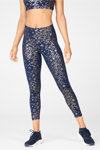

Outfits {'score': 0.7833816409111023, 'label': 'Outfits'}
[{'score': 0.7833816409111023, 'label': 'Outfits'}, {'score': 0.08544664829969406, 'label': 'Bottom'}, {'score': 0.040403444319963455, 'label': 'Bra'}, {'score': 0.021205412223935127, 'label': 'Top'}, {'score': 0.01613185741007328, 'label': 'Savage'}, {'score': 0.015208641067147255, 'label': 'Accessory'}, {'score': 0.013818852603435516, 'label': 'Underwear'}, {'score': 0.012629743665456772, 'label': 'Jacket'}, {'score': 0.011773775331676006, 'label': 'Shoes'}]


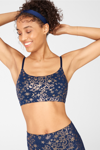

Outfits {'score': 0.6698978543281555, 'label': 'Outfits'}
[{'score': 0.6698978543281555, 'label': 'Outfits'}, {'score': 0.1619453877210617, 'label': 'Bra'}, {'score': 0.04093291983008385, 'label': 'Bottom'}, {'score': 0.0295629370957613, 'label': 'Savage'}, {'score': 0.025958657264709473, 'label': 'Accessory'}, {'score': 0.021069984883069992, 'label': 'Top'}, {'score': 0.017247548326849937, 'label': 'Underwear'}, {'score': 0.017103243619203568, 'label': 'Jacket'}, {'score': 0.016281474381685257, 'label': 'Shoes'}]


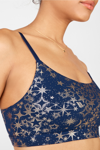

Outfits {'score': 0.5184854865074158, 'label': 'Outfits'}
[{'score': 0.5184854865074158, 'label': 'Outfits'}, {'score': 0.30391576886177063, 'label': 'Bra'}, {'score': 0.037936851382255554, 'label': 'Top'}, {'score': 0.03229532018303871, 'label': 'Savage'}, {'score': 0.027521256357431412, 'label': 'Accessory'}, {'score': 0.026663903146982193, 'label': 'Bottom'}, {'score': 0.019268063828349113, 'label': 'Jacket'}, {'score': 0.01763920485973358, 'label': 'Underwear'}, {'score': 0.01627415418624878, 'label': 'Shoes'}]


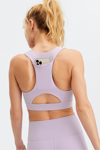

Bra {'score': 0.7107930779457092, 'label': 'Bra'}
[{'score': 0.7107930779457092, 'label': 'Bra'}, {'score': 0.07810559123754501, 'label': 'Outfits'}, {'score': 0.04980146884918213, 'label': 'Top'}, {'score': 0.04305490478873253, 'label': 'Bottom'}, {'score': 0.030892523005604744, 'label': 'Savage'}, {'score': 0.028538115322589874, 'label': 'Accessory'}, {'score': 0.022555235773324966, 'label': 'Jacket'}, {'score': 0.01817212998867035, 'label': 'Underwear'}, {'score': 0.018086932599544525, 'label': 'Shoes'}]


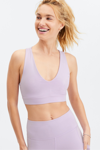

Bra {'score': 0.6808784604072571, 'label': 'Bra'}
[{'score': 0.6808784604072571, 'label': 'Bra'}, {'score': 0.12788169085979462, 'label': 'Outfits'}, {'score': 0.050962839275598526, 'label': 'Bottom'}, {'score': 0.037257350981235504, 'label': 'Top'}, {'score': 0.02774025872349739, 'label': 'Savage'}, {'score': 0.025624308735132217, 'label': 'Accessory'}, {'score': 0.019376633688807487, 'label': 'Jacket'}, {'score': 0.015460695140063763, 'label': 'Underwear'}, {'score': 0.014817756600677967, 'label': 'Shoes'}]


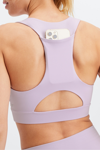

Bra {'score': 0.7426836490631104, 'label': 'Bra'}
[{'score': 0.7426836490631104, 'label': 'Bra'}, {'score': 0.08040052652359009, 'label': 'Outfits'}, {'score': 0.03067111037671566, 'label': 'Accessory'}, {'score': 0.02922833524644375, 'label': 'Bottom'}, {'score': 0.029163774102926254, 'label': 'Top'}, {'score': 0.026607925072312355, 'label': 'Savage'}, {'score': 0.023269161581993103, 'label': 'Jacket'}, {'score': 0.01923578791320324, 'label': 'Underwear'}, {'score': 0.018739698454737663, 'label': 'Shoes'}]


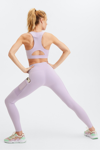

Bra {'score': 0.5861660838127136, 'label': 'Outfits'}
[{'score': 0.5861660838127136, 'label': 'Outfits'}, {'score': 0.1499442756175995, 'label': 'Bottom'}, {'score': 0.10687202960252762, 'label': 'Bra'}, {'score': 0.0678066834807396, 'label': 'Top'}, {'score': 0.02485944703221321, 'label': 'Savage'}, {'score': 0.020809395238757133, 'label': 'Accessory'}, {'score': 0.01489205565303564, 'label': 'Shoes'}, {'score': 0.014401158317923546, 'label': 'Jacket'}, {'score': 0.014248834922909737, 'label': 'Underwear'}]


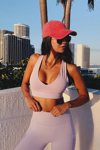

Bra {'score': 0.30329403281211853, 'label': 'Bra'}
[{'score': 0.30329403281211853, 'label': 'Bra'}, {'score': 0.22662107646465302, 'label': 'Bottom'}, {'score': 0.19734089076519012, 'label': 'Outfits'}, {'score': 0.11926030367612839, 'label': 'Top'}, {'score': 0.04793355241417885, 'label': 'Savage'}, {'score': 0.03128636255860329, 'label': 'Accessory'}, {'score': 0.028895385563373566, 'label': 'Underwear'}, {'score': 0.025304250419139862, 'label': 'Jacket'}, {'score': 0.020064154639840126, 'label': 'Shoes'}]


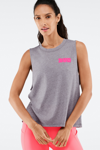

Top {'score': 0.5987011194229126, 'label': 'Top'}
[{'score': 0.5987011194229126, 'label': 'Top'}, {'score': 0.2469041645526886, 'label': 'Outfits'}, {'score': 0.0623989962041378, 'label': 'Bottom'}, {'score': 0.020857056602835655, 'label': 'Bra'}, {'score': 0.018552379682660103, 'label': 'Accessory'}, {'score': 0.01554811466485262, 'label': 'Savage'}, {'score': 0.013030672445893288, 'label': 'Shoes'}, {'score': 0.012108761817216873, 'label': 'Jacket'}, {'score': 0.011898755095899105, 'label': 'Underwear'}]


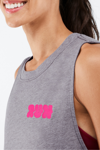

Top {'score': 0.40457332134246826, 'label': 'Top'}
[{'score': 0.40457332134246826, 'label': 'Top'}, {'score': 0.3821350336074829, 'label': 'Outfits'}, {'score': 0.09213186055421829, 'label': 'Bra'}, {'score': 0.029453719034790993, 'label': 'Bottom'}, {'score': 0.024491192772984505, 'label': 'Accessory'}, {'score': 0.01886555552482605, 'label': 'Savage'}, {'score': 0.01821160688996315, 'label': 'Jacket'}, {'score': 0.015724755823612213, 'label': 'Shoes'}, {'score': 0.01441281009465456, 'label': 'Underwear'}]


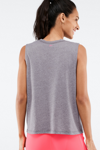

Top {'score': 0.6375839710235596, 'label': 'Top'}
[{'score': 0.6375839710235596, 'label': 'Top'}, {'score': 0.2324950248003006, 'label': 'Outfits'}, {'score': 0.04563281312584877, 'label': 'Bottom'}, {'score': 0.018510716035962105, 'label': 'Bra'}, {'score': 0.014893176965415478, 'label': 'Accessory'}, {'score': 0.013784466311335564, 'label': 'Savage'}, {'score': 0.012958740815520287, 'label': 'Underwear'}, {'score': 0.012243111617863178, 'label': 'Jacket'}, {'score': 0.011898045428097248, 'label': 'Shoes'}]


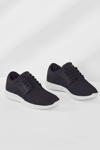

Shoes {'score': 0.3506080210208893, 'label': 'Shoes'}
[{'score': 0.3506080210208893, 'label': 'Shoes'}, {'score': 0.20207253098487854, 'label': 'Accessory'}, {'score': 0.0740075409412384, 'label': 'Underwear'}, {'score': 0.07154698669910431, 'label': 'Savage'}, {'score': 0.07023661583662033, 'label': 'Outfits'}, {'score': 0.06676329672336578, 'label': 'Bottom'}, {'score': 0.05913567543029785, 'label': 'Jacket'}, {'score': 0.053825072944164276, 'label': 'Bra'}, {'score': 0.051804281771183014, 'label': 'Top'}]


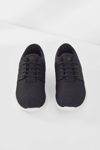

Shoes {'score': 0.31684166193008423, 'label': 'Shoes'}
[{'score': 0.31684166193008423, 'label': 'Shoes'}, {'score': 0.17943456768989563, 'label': 'Accessory'}, {'score': 0.08830341696739197, 'label': 'Savage'}, {'score': 0.08727768808603287, 'label': 'Bottom'}, {'score': 0.07817631959915161, 'label': 'Underwear'}, {'score': 0.07024984061717987, 'label': 'Top'}, {'score': 0.06329187750816345, 'label': 'Outfits'}, {'score': 0.06240064278244972, 'label': 'Jacket'}, {'score': 0.054023995995521545, 'label': 'Bra'}]


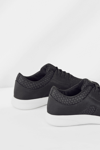

Shoes {'score': 0.35376909375190735, 'label': 'Shoes'}
[{'score': 0.35376909375190735, 'label': 'Shoes'}, {'score': 0.171977236866951, 'label': 'Accessory'}, {'score': 0.07898427546024323, 'label': 'Outfits'}, {'score': 0.075031578540802, 'label': 'Savage'}, {'score': 0.07495103031396866, 'label': 'Underwear'}, {'score': 0.07062989473342896, 'label': 'Bottom'}, {'score': 0.05966443568468094, 'label': 'Bra'}, {'score': 0.058689218014478683, 'label': 'Jacket'}, {'score': 0.05630325525999069, 'label': 'Top'}]


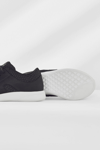

Shoes {'score': 0.34362971782684326, 'label': 'Shoes'}
[{'score': 0.34362971782684326, 'label': 'Shoes'}, {'score': 0.19672198593616486, 'label': 'Accessory'}, {'score': 0.08685261011123657, 'label': 'Outfits'}, {'score': 0.07129505276679993, 'label': 'Underwear'}, {'score': 0.07048968225717545, 'label': 'Savage'}, {'score': 0.062244173139333725, 'label': 'Bra'}, {'score': 0.05863424390554428, 'label': 'Top'}, {'score': 0.05624811723828316, 'label': 'Bottom'}, {'score': 0.053884439170360565, 'label': 'Jacket'}]


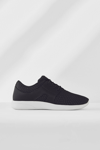

Shoes {'score': 0.332135945558548, 'label': 'Shoes'}
[{'score': 0.332135945558548, 'label': 'Shoes'}, {'score': 0.19590678811073303, 'label': 'Accessory'}, {'score': 0.08637086302042007, 'label': 'Outfits'}, {'score': 0.07616595923900604, 'label': 'Savage'}, {'score': 0.06840533763170242, 'label': 'Bottom'}, {'score': 0.06658615171909332, 'label': 'Underwear'}, {'score': 0.06557643413543701, 'label': 'Top'}, {'score': 0.055966053158044815, 'label': 'Bra'}, {'score': 0.0528864860534668, 'label': 'Jacket'}]


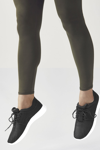

Shoes {'score': 0.7888868451118469, 'label': 'Bottom'}
[{'score': 0.7888868451118469, 'label': 'Bottom'}, {'score': 0.08421214669942856, 'label': 'Outfits'}, {'score': 0.031146308407187462, 'label': 'Top'}, {'score': 0.020080117508769035, 'label': 'Underwear'}, {'score': 0.01855374313890934, 'label': 'Accessory'}, {'score': 0.015448975376784801, 'label': 'Bra'}, {'score': 0.014851666055619717, 'label': 'Shoes'}, {'score': 0.014132837764918804, 'label': 'Savage'}, {'score': 0.01268734596669674, 'label': 'Jacket'}]


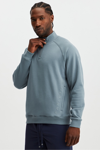

Top {'score': 0.6411903500556946, 'label': 'Top'}
[{'score': 0.6411903500556946, 'label': 'Top'}, {'score': 0.13129332661628723, 'label': 'Outfits'}, {'score': 0.12137706577777863, 'label': 'Bottom'}, {'score': 0.02444544807076454, 'label': 'Accessory'}, {'score': 0.02036992460489273, 'label': 'Savage'}, {'score': 0.01603975147008896, 'label': 'Shoes'}, {'score': 0.015979960560798645, 'label': 'Bra'}, {'score': 0.015580917708575726, 'label': 'Underwear'}, {'score': 0.013723219744861126, 'label': 'Jacket'}]


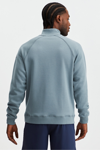

Top {'score': 0.6700399518013, 'label': 'Top'}
[{'score': 0.6700399518013, 'label': 'Top'}, {'score': 0.17093652486801147, 'label': 'Outfits'}, {'score': 0.07152770459651947, 'label': 'Bottom'}, {'score': 0.016902390867471695, 'label': 'Accessory'}, {'score': 0.01610085368156433, 'label': 'Savage'}, {'score': 0.01455166656523943, 'label': 'Bra'}, {'score': 0.013568412512540817, 'label': 'Shoes'}, {'score': 0.013213096186518669, 'label': 'Underwear'}, {'score': 0.013159295544028282, 'label': 'Jacket'}]


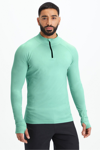

Top {'score': 0.7160722017288208, 'label': 'Top'}
[{'score': 0.7160722017288208, 'label': 'Top'}, {'score': 0.12528392672538757, 'label': 'Outfits'}, {'score': 0.06855588406324387, 'label': 'Bottom'}, {'score': 0.016927555203437805, 'label': 'Bra'}, {'score': 0.016839778050780296, 'label': 'Accessory'}, {'score': 0.015389716252684593, 'label': 'Savage'}, {'score': 0.014446688815951347, 'label': 'Underwear'}, {'score': 0.013660714030265808, 'label': 'Shoes'}, {'score': 0.012823599390685558, 'label': 'Jacket'}]


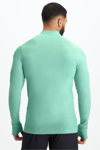

Top {'score': 0.764746904373169, 'label': 'Top'}
[{'score': 0.764746904373169, 'label': 'Top'}, {'score': 0.07982475310564041, 'label': 'Outfits'}, {'score': 0.06183365359902382, 'label': 'Bottom'}, {'score': 0.01795961894094944, 'label': 'Bra'}, {'score': 0.01760750822722912, 'label': 'Accessory'}, {'score': 0.01727268472313881, 'label': 'Savage'}, {'score': 0.01444457657635212, 'label': 'Shoes'}, {'score': 0.013745622709393501, 'label': 'Underwear'}, {'score': 0.012564731761813164, 'label': 'Jacket'}]


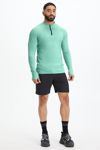

Top {'score': 0.39022931456565857, 'label': 'Top'}
[{'score': 0.39022931456565857, 'label': 'Top'}, {'score': 0.2979761064052582, 'label': 'Bottom'}, {'score': 0.19937579333782196, 'label': 'Outfits'}, {'score': 0.02655123360455036, 'label': 'Bra'}, {'score': 0.020126977935433388, 'label': 'Accessory'}, {'score': 0.018929628655314445, 'label': 'Underwear'}, {'score': 0.01723652519285679, 'label': 'Shoes'}, {'score': 0.01541000884026289, 'label': 'Savage'}, {'score': 0.014164554886519909, 'label': 'Jacket'}]


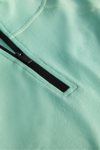

Top {'score': 0.5844760537147522, 'label': 'Top'}
[{'score': 0.5844760537147522, 'label': 'Top'}, {'score': 0.1823732554912567, 'label': 'Outfits'}, {'score': 0.11337824910879135, 'label': 'Bottom'}, {'score': 0.026584435254335403, 'label': 'Bra'}, {'score': 0.026091311126947403, 'label': 'Accessory'}, {'score': 0.019403988495469093, 'label': 'Savage'}, {'score': 0.01921427622437477, 'label': 'Underwear'}, {'score': 0.014513383619487286, 'label': 'Shoes'}, {'score': 0.01396509725600481, 'label': 'Jacket'}]


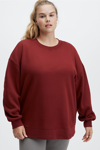

Top {'score': 0.7513679265975952, 'label': 'Top'}
[{'score': 0.7513679265975952, 'label': 'Top'}, {'score': 0.1212509274482727, 'label': 'Outfits'}, {'score': 0.04556970298290253, 'label': 'Bottom'}, {'score': 0.017116399481892586, 'label': 'Accessory'}, {'score': 0.014334067702293396, 'label': 'Bra'}, {'score': 0.014248832128942013, 'label': 'Savage'}, {'score': 0.012805197387933731, 'label': 'Shoes'}, {'score': 0.01193403173238039, 'label': 'Underwear'}, {'score': 0.011372891254723072, 'label': 'Jacket'}]


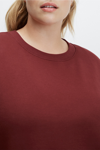

Top {'score': 0.8139978051185608, 'label': 'Top'}
[{'score': 0.8139978051185608, 'label': 'Top'}, {'score': 0.066168874502182, 'label': 'Outfits'}, {'score': 0.0235800351947546, 'label': 'Bottom'}, {'score': 0.022897306829690933, 'label': 'Bra'}, {'score': 0.020185308530926704, 'label': 'Accessory'}, {'score': 0.015902366489171982, 'label': 'Savage'}, {'score': 0.013949327170848846, 'label': 'Shoes'}, {'score': 0.012010321021080017, 'label': 'Underwear'}, {'score': 0.011308479122817516, 'label': 'Jacket'}]


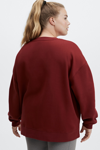

Top {'score': 0.7777044773101807, 'label': 'Top'}
[{'score': 0.7777044773101807, 'label': 'Top'}, {'score': 0.09503080695867538, 'label': 'Outfits'}, {'score': 0.03945289924740791, 'label': 'Bottom'}, {'score': 0.019183944910764694, 'label': 'Accessory'}, {'score': 0.014864797703921795, 'label': 'Savage'}, {'score': 0.01411481760442257, 'label': 'Bra'}, {'score': 0.01399199292063713, 'label': 'Shoes'}, {'score': 0.013406270183622837, 'label': 'Underwear'}, {'score': 0.012250040657818317, 'label': 'Jacket'}]


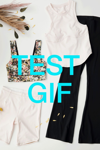

Outfits {'score': 0.6132210493087769, 'label': 'Outfits'}
[{'score': 0.6132210493087769, 'label': 'Outfits'}, {'score': 0.1905382126569748, 'label': 'Top'}, {'score': 0.04277554526925087, 'label': 'Bra'}, {'score': 0.03870461508631706, 'label': 'Accessory'}, {'score': 0.029775816947221756, 'label': 'Bottom'}, {'score': 0.027287323027849197, 'label': 'Savage'}, {'score': 0.02136228419840336, 'label': 'Underwear'}, {'score': 0.019755680114030838, 'label': 'Shoes'}, {'score': 0.01657947152853012, 'label': 'Jacket'}]


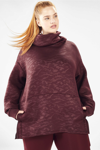

Outfits {'score': 0.7603439688682556, 'label': 'Top'}
[{'score': 0.7603439688682556, 'label': 'Top'}, {'score': 0.10442262142896652, 'label': 'Outfits'}, {'score': 0.04501623660326004, 'label': 'Bottom'}, {'score': 0.022471362724900246, 'label': 'Accessory'}, {'score': 0.015206892974674702, 'label': 'Savage'}, {'score': 0.014931798912584782, 'label': 'Shoes'}, {'score': 0.013348587788641453, 'label': 'Underwear'}, {'score': 0.012926345691084862, 'label': 'Bra'}, {'score': 0.011332284659147263, 'label': 'Jacket'}]


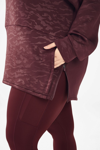

Outfits {'score': 0.40821942687034607, 'label': 'Top'}
[{'score': 0.40821942687034607, 'label': 'Top'}, {'score': 0.3087323009967804, 'label': 'Bottom'}, {'score': 0.1627713143825531, 'label': 'Outfits'}, {'score': 0.02875595912337303, 'label': 'Accessory'}, {'score': 0.02298794500529766, 'label': 'Underwear'}, {'score': 0.02086743712425232, 'label': 'Savage'}, {'score': 0.018032342195510864, 'label': 'Shoes'}, {'score': 0.016875294968485832, 'label': 'Bra'}, {'score': 0.012757863849401474, 'label': 'Jacket'}]


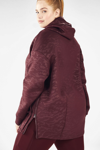

Outfits {'score': 0.7452266216278076, 'label': 'Top'}
[{'score': 0.7452266216278076, 'label': 'Top'}, {'score': 0.08810998499393463, 'label': 'Outfits'}, {'score': 0.06950031220912933, 'label': 'Bottom'}, {'score': 0.02270682528614998, 'label': 'Accessory'}, {'score': 0.017088305205106735, 'label': 'Savage'}, {'score': 0.016358118504285812, 'label': 'Underwear'}, {'score': 0.016210615634918213, 'label': 'Shoes'}, {'score': 0.013070879504084587, 'label': 'Bra'}, {'score': 0.01172834262251854, 'label': 'Jacket'}]


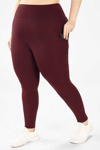

Outfits {'score': 0.5915533900260925, 'label': 'Bottom'}
[{'score': 0.5915533900260925, 'label': 'Bottom'}, {'score': 0.28517934679985046, 'label': 'Outfits'}, {'score': 0.027451833710074425, 'label': 'Top'}, {'score': 0.022615205496549606, 'label': 'Bra'}, {'score': 0.019650930538773537, 'label': 'Underwear'}, {'score': 0.015415544621646404, 'label': 'Accessory'}, {'score': 0.01457370724529028, 'label': 'Savage'}, {'score': 0.012029662728309631, 'label': 'Shoes'}, {'score': 0.0115303760394454, 'label': 'Jacket'}]


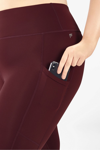

Outfits {'score': 0.5632228851318359, 'label': 'Bottom'}
[{'score': 0.5632228851318359, 'label': 'Bottom'}, {'score': 0.3064493238925934, 'label': 'Outfits'}, {'score': 0.0246029794216156, 'label': 'Bra'}, {'score': 0.0239480622112751, 'label': 'Top'}, {'score': 0.021976621821522713, 'label': 'Underwear'}, {'score': 0.016616901382803917, 'label': 'Accessory'}, {'score': 0.015180407091975212, 'label': 'Savage'}, {'score': 0.014304770156741142, 'label': 'Shoes'}, {'score': 0.013698041439056396, 'label': 'Jacket'}]


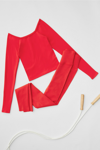

Outfits {'score': 0.5264166593551636, 'label': 'Outfits'}
[{'score': 0.5264166593551636, 'label': 'Outfits'}, {'score': 0.14935708045959473, 'label': 'Accessory'}, {'score': 0.06268750131130219, 'label': 'Bra'}, {'score': 0.054065048694610596, 'label': 'Bottom'}, {'score': 0.05233767628669739, 'label': 'Savage'}, {'score': 0.05106343701481819, 'label': 'Shoes'}, {'score': 0.04095017537474632, 'label': 'Underwear'}, {'score': 0.03400195389986038, 'label': 'Top'}, {'score': 0.02912045642733574, 'label': 'Jacket'}]


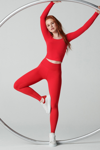

Outfits {'score': 0.4688761532306671, 'label': 'Outfits'}
[{'score': 0.4688761532306671, 'label': 'Outfits'}, {'score': 0.20176555216312408, 'label': 'Bottom'}, {'score': 0.12533175945281982, 'label': 'Top'}, {'score': 0.08824653923511505, 'label': 'Bra'}, {'score': 0.03637981042265892, 'label': 'Accessory'}, {'score': 0.025934206321835518, 'label': 'Savage'}, {'score': 0.020149828866124153, 'label': 'Shoes'}, {'score': 0.017542550340294838, 'label': 'Underwear'}, {'score': 0.01577349193394184, 'label': 'Jacket'}]


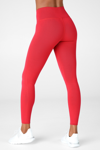

Outfits {'score': 0.509404718875885, 'label': 'Outfits'}
[{'score': 0.509404718875885, 'label': 'Outfits'}, {'score': 0.3501245081424713, 'label': 'Bottom'}, {'score': 0.039945244789123535, 'label': 'Bra'}, {'score': 0.026268310844898224, 'label': 'Top'}, {'score': 0.018328707665205002, 'label': 'Accessory'}, {'score': 0.01646088995039463, 'label': 'Underwear'}, {'score': 0.015099065378308296, 'label': 'Savage'}, {'score': 0.012484291568398476, 'label': 'Shoes'}, {'score': 0.011884321458637714, 'label': 'Jacket'}]


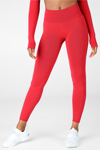

Outfits {'score': 0.68533855676651, 'label': 'Outfits'}
[{'score': 0.68533855676651, 'label': 'Outfits'}, {'score': 0.1701715588569641, 'label': 'Bottom'}, {'score': 0.053930509835481644, 'label': 'Top'}, {'score': 0.029972927644848824, 'label': 'Bra'}, {'score': 0.014703878201544285, 'label': 'Accessory'}, {'score': 0.012968546710908413, 'label': 'Savage'}, {'score': 0.012220964767038822, 'label': 'Underwear'}, {'score': 0.010515651665627956, 'label': 'Jacket'}, {'score': 0.010177355259656906, 'label': 'Shoes'}]


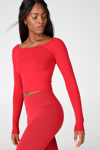

Outfits {'score': 0.4053950607776642, 'label': 'Outfits'}
[{'score': 0.4053950607776642, 'label': 'Outfits'}, {'score': 0.3474631905555725, 'label': 'Top'}, {'score': 0.13951975107192993, 'label': 'Bottom'}, {'score': 0.038186170160770416, 'label': 'Bra'}, {'score': 0.01572272554039955, 'label': 'Savage'}, {'score': 0.015601344406604767, 'label': 'Accessory'}, {'score': 0.013123502023518085, 'label': 'Underwear'}, {'score': 0.012886465527117252, 'label': 'Jacket'}, {'score': 0.012101740576326847, 'label': 'Shoes'}]


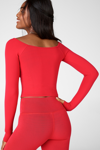

Outfits {'score': 0.5260259509086609, 'label': 'Outfits'}
[{'score': 0.5260259509086609, 'label': 'Outfits'}, {'score': 0.26227861642837524, 'label': 'Top'}, {'score': 0.11133991181850433, 'label': 'Bottom'}, {'score': 0.032721202820539474, 'label': 'Bra'}, {'score': 0.015975939109921455, 'label': 'Accessory'}, {'score': 0.014338057488203049, 'label': 'Savage'}, {'score': 0.013691389933228493, 'label': 'Underwear'}, {'score': 0.012280621565878391, 'label': 'Jacket'}, {'score': 0.01134844496846199, 'label': 'Shoes'}]


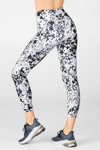

Bottom {'score': 0.4790913462638855, 'label': 'Bottom'}
[{'score': 0.4790913462638855, 'label': 'Bottom'}, {'score': 0.3832707703113556, 'label': 'Outfits'}, {'score': 0.03185633569955826, 'label': 'Bra'}, {'score': 0.025223374366760254, 'label': 'Top'}, {'score': 0.02052704617381096, 'label': 'Underwear'}, {'score': 0.016900936141610146, 'label': 'Accessory'}, {'score': 0.01617393270134926, 'label': 'Savage'}, {'score': 0.014273292385041714, 'label': 'Shoes'}, {'score': 0.012683020904660225, 'label': 'Jacket'}]


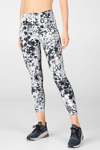

Bottom {'score': 0.5339435338973999, 'label': 'Outfits'}
[{'score': 0.5339435338973999, 'label': 'Outfits'}, {'score': 0.33151373267173767, 'label': 'Bottom'}, {'score': 0.03971598669886589, 'label': 'Top'}, {'score': 0.02488437481224537, 'label': 'Bra'}, {'score': 0.017768044024705887, 'label': 'Underwear'}, {'score': 0.015023675747215748, 'label': 'Accessory'}, {'score': 0.01368135865777731, 'label': 'Savage'}, {'score': 0.012015528045594692, 'label': 'Shoes'}, {'score': 0.01145380549132824, 'label': 'Jacket'}]


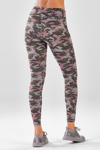

Bottom {'score': 0.6304330229759216, 'label': 'Bottom'}
[{'score': 0.6304330229759216, 'label': 'Bottom'}, {'score': 0.23555101454257965, 'label': 'Outfits'}, {'score': 0.029335491359233856, 'label': 'Top'}, {'score': 0.025095559656620026, 'label': 'Bra'}, {'score': 0.020240195095539093, 'label': 'Underwear'}, {'score': 0.018648160621523857, 'label': 'Accessory'}, {'score': 0.016388094052672386, 'label': 'Savage'}, {'score': 0.012869791127741337, 'label': 'Shoes'}, {'score': 0.01143865566700697, 'label': 'Jacket'}]


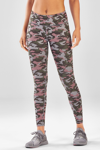

Bottom {'score': 0.5348351001739502, 'label': 'Bottom'}
[{'score': 0.5348351001739502, 'label': 'Bottom'}, {'score': 0.33276209235191345, 'label': 'Outfits'}, {'score': 0.0271342471241951, 'label': 'Bra'}, {'score': 0.025885550305247307, 'label': 'Top'}, {'score': 0.020621459931135178, 'label': 'Underwear'}, {'score': 0.01715025119483471, 'label': 'Savage'}, {'score': 0.016882941126823425, 'label': 'Accessory'}, {'score': 0.012694166973233223, 'label': 'Shoes'}, {'score': 0.012034225277602673, 'label': 'Jacket'}]


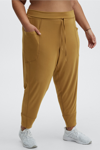

Bottom {'score': 0.8101901412010193, 'label': 'Bottom'}
[{'score': 0.8101901412010193, 'label': 'Bottom'}, {'score': 0.04370039328932762, 'label': 'Outfits'}, {'score': 0.03378596529364586, 'label': 'Top'}, {'score': 0.026703810319304466, 'label': 'Underwear'}, {'score': 0.020337838679552078, 'label': 'Savage'}, {'score': 0.01907622255384922, 'label': 'Accessory'}, {'score': 0.017597012221813202, 'label': 'Bra'}, {'score': 0.014464414678514004, 'label': 'Shoes'}, {'score': 0.014144317246973515, 'label': 'Jacket'}]


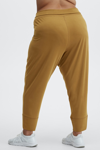

Bottom {'score': 0.805443525314331, 'label': 'Bottom'}
[{'score': 0.805443525314331, 'label': 'Bottom'}, {'score': 0.05242380499839783, 'label': 'Outfits'}, {'score': 0.03720524534583092, 'label': 'Top'}, {'score': 0.022913258522748947, 'label': 'Underwear'}, {'score': 0.020758021622896194, 'label': 'Bra'}, {'score': 0.01807531900703907, 'label': 'Accessory'}, {'score': 0.017465179786086082, 'label': 'Savage'}, {'score': 0.013135750778019428, 'label': 'Shoes'}, {'score': 0.01257988903671503, 'label': 'Jacket'}]


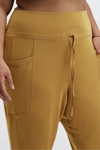

Bottom {'score': 0.7993850708007812, 'label': 'Bottom'}
[{'score': 0.7993850708007812, 'label': 'Bottom'}, {'score': 0.04636456072330475, 'label': 'Outfits'}, {'score': 0.03352608159184456, 'label': 'Underwear'}, {'score': 0.03318524360656738, 'label': 'Top'}, {'score': 0.02027735859155655, 'label': 'Savage'}, {'score': 0.019900890067219734, 'label': 'Bra'}, {'score': 0.018782861530780792, 'label': 'Accessory'}, {'score': 0.01489128265529871, 'label': 'Shoes'}, {'score': 0.013686656020581722, 'label': 'Jacket'}]


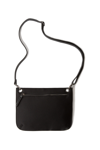

Accessory {'score': 0.3959018588066101, 'label': 'Accessory'}
[{'score': 0.3959018588066101, 'label': 'Accessory'}, {'score': 0.09164147078990936, 'label': 'Bottom'}, {'score': 0.09143834561109543, 'label': 'Top'}, {'score': 0.0838799998164177, 'label': 'Shoes'}, {'score': 0.082608163356781, 'label': 'Outfits'}, {'score': 0.08240265399217606, 'label': 'Savage'}, {'score': 0.07786572724580765, 'label': 'Bra'}, {'score': 0.05649818852543831, 'label': 'Underwear'}, {'score': 0.03776351362466812, 'label': 'Jacket'}]


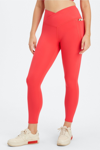

Bottom {'score': 0.6508193612098694, 'label': 'Bottom'}
[{'score': 0.6508193612098694, 'label': 'Bottom'}, {'score': 0.21923695504665375, 'label': 'Outfits'}, {'score': 0.03196744620800018, 'label': 'Top'}, {'score': 0.02800435945391655, 'label': 'Bra'}, {'score': 0.017449114471673965, 'label': 'Underwear'}, {'score': 0.0162905752658844, 'label': 'Accessory'}, {'score': 0.013282558880746365, 'label': 'Savage'}, {'score': 0.01186804473400116, 'label': 'Shoes'}, {'score': 0.011081594973802567, 'label': 'Jacket'}]


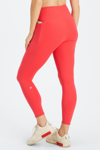

Bottom {'score': 0.5297491550445557, 'label': 'Bottom'}
[{'score': 0.5297491550445557, 'label': 'Bottom'}, {'score': 0.3033207654953003, 'label': 'Outfits'}, {'score': 0.048574525862932205, 'label': 'Bra'}, {'score': 0.047396574169397354, 'label': 'Top'}, {'score': 0.017148030921816826, 'label': 'Accessory'}, {'score': 0.016019834205508232, 'label': 'Underwear'}, {'score': 0.014815385453402996, 'label': 'Savage'}, {'score': 0.01180722564458847, 'label': 'Shoes'}, {'score': 0.011168592609465122, 'label': 'Jacket'}]


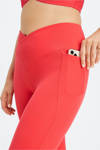

Bottom {'score': 0.6169832348823547, 'label': 'Bottom'}
[{'score': 0.6169832348823547, 'label': 'Bottom'}, {'score': 0.22821012139320374, 'label': 'Outfits'}, {'score': 0.04991111531853676, 'label': 'Bra'}, {'score': 0.02243124321103096, 'label': 'Top'}, {'score': 0.020051805302500725, 'label': 'Underwear'}, {'score': 0.018229901790618896, 'label': 'Accessory'}, {'score': 0.017626548185944557, 'label': 'Savage'}, {'score': 0.0135208023712039, 'label': 'Shoes'}, {'score': 0.013035116717219353, 'label': 'Jacket'}]


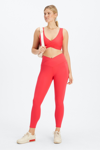

Bottom {'score': 0.4890533685684204, 'label': 'Outfits'}
[{'score': 0.4890533685684204, 'label': 'Outfits'}, {'score': 0.25654137134552, 'label': 'Bottom'}, {'score': 0.10963209718465805, 'label': 'Bra'}, {'score': 0.0554373674094677, 'label': 'Top'}, {'score': 0.02461577206850052, 'label': 'Savage'}, {'score': 0.022706393152475357, 'label': 'Accessory'}, {'score': 0.014330769889056683, 'label': 'Underwear'}, {'score': 0.014217108488082886, 'label': 'Jacket'}, {'score': 0.013465738855302334, 'label': 'Shoes'}]


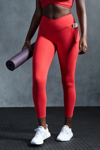

Bottom {'score': 0.7229059338569641, 'label': 'Bottom'}
[{'score': 0.7229059338569641, 'label': 'Bottom'}, {'score': 0.08430318534374237, 'label': 'Outfits'}, {'score': 0.057825520634651184, 'label': 'Top'}, {'score': 0.047365229576826096, 'label': 'Bra'}, {'score': 0.023147983476519585, 'label': 'Underwear'}, {'score': 0.01931818202137947, 'label': 'Accessory'}, {'score': 0.01826603151857853, 'label': 'Savage'}, {'score': 0.01383882574737072, 'label': 'Jacket'}, {'score': 0.013029118999838829, 'label': 'Shoes'}]


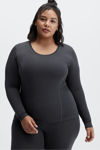

Top {'score': 0.7296081781387329, 'label': 'Top'}
[{'score': 0.7296081781387329, 'label': 'Top'}, {'score': 0.10495468974113464, 'label': 'Bottom'}, {'score': 0.07220319658517838, 'label': 'Outfits'}, {'score': 0.018693778663873672, 'label': 'Bra'}, {'score': 0.017368992790579796, 'label': 'Savage'}, {'score': 0.016573086380958557, 'label': 'Accessory'}, {'score': 0.01397407054901123, 'label': 'Shoes'}, {'score': 0.01389192696660757, 'label': 'Underwear'}, {'score': 0.012732020579278469, 'label': 'Jacket'}]


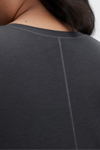

Top {'score': 0.7894138097763062, 'label': 'Top'}
[{'score': 0.7894138097763062, 'label': 'Top'}, {'score': 0.0716836079955101, 'label': 'Outfits'}, {'score': 0.030682185664772987, 'label': 'Bra'}, {'score': 0.02797987125813961, 'label': 'Bottom'}, {'score': 0.02202763594686985, 'label': 'Accessory'}, {'score': 0.019669553264975548, 'label': 'Savage'}, {'score': 0.013795141130685806, 'label': 'Shoes'}, {'score': 0.013345046900212765, 'label': 'Underwear'}, {'score': 0.011403302662074566, 'label': 'Jacket'}]


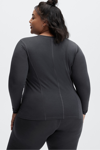

Top {'score': 0.7202546000480652, 'label': 'Top'}
[{'score': 0.7202546000480652, 'label': 'Top'}, {'score': 0.11398661136627197, 'label': 'Bottom'}, {'score': 0.05929430201649666, 'label': 'Outfits'}, {'score': 0.020723089575767517, 'label': 'Savage'}, {'score': 0.020171474665403366, 'label': 'Accessory'}, {'score': 0.01799226738512516, 'label': 'Underwear'}, {'score': 0.017218535766005516, 'label': 'Bra'}, {'score': 0.016716573387384415, 'label': 'Shoes'}, {'score': 0.013642589561641216, 'label': 'Jacket'}]


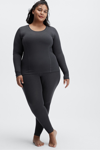

Top {'score': 0.5331667065620422, 'label': 'Bottom'}
[{'score': 0.5331667065620422, 'label': 'Bottom'}, {'score': 0.2548593282699585, 'label': 'Top'}, {'score': 0.0911354199051857, 'label': 'Outfits'}, {'score': 0.024884440004825592, 'label': 'Bra'}, {'score': 0.022878216579556465, 'label': 'Accessory'}, {'score': 0.020406702533364296, 'label': 'Underwear'}, {'score': 0.01976410485804081, 'label': 'Savage'}, {'score': 0.01770906150341034, 'label': 'Shoes'}, {'score': 0.015196082182228565, 'label': 'Jacket'}]


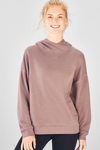

Top {'score': 0.7192954421043396, 'label': 'Top'}
[{'score': 0.7192954421043396, 'label': 'Top'}, {'score': 0.1500970423221588, 'label': 'Outfits'}, {'score': 0.046558454632759094, 'label': 'Bottom'}, {'score': 0.016825685277581215, 'label': 'Accessory'}, {'score': 0.015077086165547371, 'label': 'Savage'}, {'score': 0.014154685661196709, 'label': 'Shoes'}, {'score': 0.01289401762187481, 'label': 'Jacket'}, {'score': 0.012557176873087883, 'label': 'Bra'}, {'score': 0.012540488503873348, 'label': 'Underwear'}]


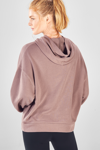

Top {'score': 0.6899073123931885, 'label': 'Top'}
[{'score': 0.6899073123931885, 'label': 'Top'}, {'score': 0.17512653768062592, 'label': 'Outfits'}, {'score': 0.04614470526576042, 'label': 'Bottom'}, {'score': 0.01903652399778366, 'label': 'Accessory'}, {'score': 0.015730008482933044, 'label': 'Savage'}, {'score': 0.013790186494588852, 'label': 'Bra'}, {'score': 0.0137565266340971, 'label': 'Jacket'}, {'score': 0.013337562792003155, 'label': 'Shoes'}, {'score': 0.013170617632567883, 'label': 'Underwear'}]


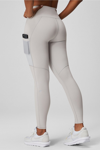

Bottom {'score': 0.6984230279922485, 'label': 'Bottom'}
[{'score': 0.6984230279922485, 'label': 'Bottom'}, {'score': 0.16352814435958862, 'label': 'Outfits'}, {'score': 0.046629924327135086, 'label': 'Top'}, {'score': 0.023563843220472336, 'label': 'Bra'}, {'score': 0.017057916149497032, 'label': 'Underwear'}, {'score': 0.014857030473649502, 'label': 'Savage'}, {'score': 0.013994677923619747, 'label': 'Accessory'}, {'score': 0.011126022785902023, 'label': 'Shoes'}, {'score': 0.010819429531693459, 'label': 'Jacket'}]


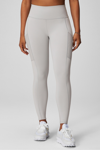

Bottom {'score': 0.7410411238670349, 'label': 'Bottom'}
[{'score': 0.7410411238670349, 'label': 'Bottom'}, {'score': 0.12847238779067993, 'label': 'Outfits'}, {'score': 0.03874592483043671, 'label': 'Top'}, {'score': 0.023251723498106003, 'label': 'Bra'}, {'score': 0.018386617302894592, 'label': 'Underwear'}, {'score': 0.014785739593207836, 'label': 'Savage'}, {'score': 0.013454090803861618, 'label': 'Accessory'}, {'score': 0.010998888872563839, 'label': 'Jacket'}, {'score': 0.010863457806408405, 'label': 'Shoes'}]


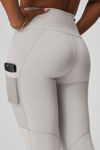

Bottom {'score': 0.739255428314209, 'label': 'Bottom'}
[{'score': 0.739255428314209, 'label': 'Bottom'}, {'score': 0.13181902468204498, 'label': 'Outfits'}, {'score': 0.025448817759752274, 'label': 'Top'}, {'score': 0.024070072919130325, 'label': 'Underwear'}, {'score': 0.02375948056578636, 'label': 'Bra'}, {'score': 0.016822991892695427, 'label': 'Savage'}, {'score': 0.014045275747776031, 'label': 'Accessory'}, {'score': 0.012558026239275932, 'label': 'Shoes'}, {'score': 0.012220809236168861, 'label': 'Jacket'}]


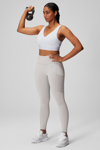

Bottom {'score': 0.6262505650520325, 'label': 'Bottom'}
[{'score': 0.6262505650520325, 'label': 'Bottom'}, {'score': 0.16022108495235443, 'label': 'Outfits'}, {'score': 0.0710281953215599, 'label': 'Bra'}, {'score': 0.05639771372079849, 'label': 'Top'}, {'score': 0.019861027598381042, 'label': 'Savage'}, {'score': 0.019431449472904205, 'label': 'Underwear'}, {'score': 0.01833154447376728, 'label': 'Accessory'}, {'score': 0.01445392519235611, 'label': 'Jacket'}, {'score': 0.01402442716062069, 'label': 'Shoes'}]


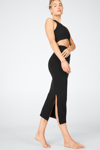

Outfits {'score': 0.760445237159729, 'label': 'Outfits'}
[{'score': 0.760445237159729, 'label': 'Outfits'}, {'score': 0.08374933153390884, 'label': 'Bottom'}, {'score': 0.06250473856925964, 'label': 'Top'}, {'score': 0.02708323858678341, 'label': 'Bra'}, {'score': 0.01827712170779705, 'label': 'Accessory'}, {'score': 0.013865625485777855, 'label': 'Savage'}, {'score': 0.011880630627274513, 'label': 'Shoes'}, {'score': 0.011336739175021648, 'label': 'Underwear'}, {'score': 0.010857383720576763, 'label': 'Jacket'}]


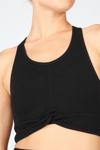

Outfits {'score': 0.41443198919296265, 'label': 'Outfits'}
[{'score': 0.41443198919296265, 'label': 'Outfits'}, {'score': 0.38036051392555237, 'label': 'Bra'}, {'score': 0.08294089883565903, 'label': 'Top'}, {'score': 0.030985435470938683, 'label': 'Bottom'}, {'score': 0.025901759043335915, 'label': 'Accessory'}, {'score': 0.018948663026094437, 'label': 'Savage'}, {'score': 0.017652984708547592, 'label': 'Jacket'}, {'score': 0.014590801671147346, 'label': 'Underwear'}, {'score': 0.01418687216937542, 'label': 'Shoes'}]


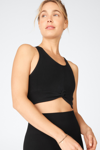

Outfits {'score': 0.3936731517314911, 'label': 'Outfits'}
[{'score': 0.3936731517314911, 'label': 'Outfits'}, {'score': 0.2840328812599182, 'label': 'Bra'}, {'score': 0.12932232022285461, 'label': 'Bottom'}, {'score': 0.09178769588470459, 'label': 'Top'}, {'score': 0.030663440003991127, 'label': 'Accessory'}, {'score': 0.021435176953673363, 'label': 'Savage'}, {'score': 0.01810912787914276, 'label': 'Jacket'}, {'score': 0.015826666727662086, 'label': 'Shoes'}, {'score': 0.015149520710110664, 'label': 'Underwear'}]


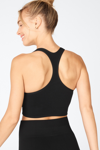

Outfits {'score': 0.5109037756919861, 'label': 'Outfits'}
[{'score': 0.5109037756919861, 'label': 'Outfits'}, {'score': 0.25443053245544434, 'label': 'Bra'}, {'score': 0.08764569461345673, 'label': 'Top'}, {'score': 0.059836577624082565, 'label': 'Bottom'}, {'score': 0.02270542085170746, 'label': 'Accessory'}, {'score': 0.018152503296732903, 'label': 'Jacket'}, {'score': 0.016320567578077316, 'label': 'Underwear'}, {'score': 0.015267190523445606, 'label': 'Shoes'}, {'score': 0.014737740159034729, 'label': 'Savage'}]


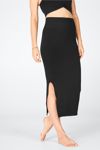

Outfits {'score': 0.44071856141090393, 'label': 'Bottom'}
[{'score': 0.44071856141090393, 'label': 'Bottom'}, {'score': 0.3921140432357788, 'label': 'Outfits'}, {'score': 0.05597051605582237, 'label': 'Top'}, {'score': 0.0348646454513073, 'label': 'Bra'}, {'score': 0.020644187927246094, 'label': 'Accessory'}, {'score': 0.015706725418567657, 'label': 'Underwear'}, {'score': 0.01445050723850727, 'label': 'Savage'}, {'score': 0.01341263297945261, 'label': 'Shoes'}, {'score': 0.012118199840188026, 'label': 'Jacket'}]


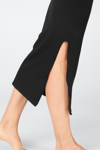

Outfits {'score': 0.44909021258354187, 'label': 'Outfits'}
[{'score': 0.44909021258354187, 'label': 'Outfits'}, {'score': 0.40078043937683105, 'label': 'Bottom'}, {'score': 0.0386323407292366, 'label': 'Top'}, {'score': 0.02613719366490841, 'label': 'Accessory'}, {'score': 0.02140694297850132, 'label': 'Bra'}, {'score': 0.019326893612742424, 'label': 'Shoes'}, {'score': 0.017228292301297188, 'label': 'Underwear'}, {'score': 0.014637768268585205, 'label': 'Savage'}, {'score': 0.012759874574840069, 'label': 'Jacket'}]


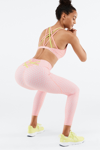

Outfits {'score': 0.5996208786964417, 'label': 'Outfits'}
[{'score': 0.5996208786964417, 'label': 'Outfits'}, {'score': 0.1352432668209076, 'label': 'Bottom'}, {'score': 0.08554501086473465, 'label': 'Bra'}, {'score': 0.06656841188669205, 'label': 'Savage'}, {'score': 0.032976020127534866, 'label': 'Top'}, {'score': 0.029962392523884773, 'label': 'Accessory'}, {'score': 0.01756606437265873, 'label': 'Underwear'}, {'score': 0.01713447831571102, 'label': 'Shoes'}, {'score': 0.015383460558950901, 'label': 'Jacket'}]


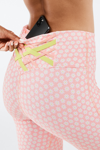

Outfits {'score': 0.5746713280677795, 'label': 'Outfits'}
[{'score': 0.5746713280677795, 'label': 'Outfits'}, {'score': 0.24746736884117126, 'label': 'Bottom'}, {'score': 0.05250762030482292, 'label': 'Bra'}, {'score': 0.028382355347275734, 'label': 'Savage'}, {'score': 0.023739919066429138, 'label': 'Accessory'}, {'score': 0.023039009422063828, 'label': 'Underwear'}, {'score': 0.02276172675192356, 'label': 'Top'}, {'score': 0.014193609356880188, 'label': 'Shoes'}, {'score': 0.013237036764621735, 'label': 'Jacket'}]


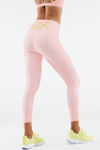

Outfits {'score': 0.6531140804290771, 'label': 'Outfits'}
[{'score': 0.6531140804290771, 'label': 'Outfits'}, {'score': 0.13542106747627258, 'label': 'Bottom'}, {'score': 0.0703471302986145, 'label': 'Bra'}, {'score': 0.037974100559949875, 'label': 'Top'}, {'score': 0.03732479736208916, 'label': 'Savage'}, {'score': 0.025037137791514397, 'label': 'Accessory'}, {'score': 0.014751631766557693, 'label': 'Underwear'}, {'score': 0.0131498072296381, 'label': 'Shoes'}, {'score': 0.012880340218544006, 'label': 'Jacket'}]


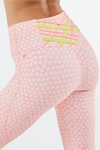

Outfits {'score': 0.7824944853782654, 'label': 'Outfits'}
[{'score': 0.7824944853782654, 'label': 'Outfits'}, {'score': 0.07912328839302063, 'label': 'Bottom'}, {'score': 0.040502142161130905, 'label': 'Bra'}, {'score': 0.023095114156603813, 'label': 'Top'}, {'score': 0.018352050334215164, 'label': 'Savage'}, {'score': 0.017612552270293236, 'label': 'Accessory'}, {'score': 0.01458452083170414, 'label': 'Underwear'}, {'score': 0.012598074041306973, 'label': 'Shoes'}, {'score': 0.011637675575911999, 'label': 'Jacket'}]


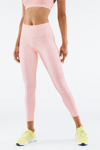

Outfits {'score': 0.641739010810852, 'label': 'Outfits'}
[{'score': 0.641739010810852, 'label': 'Outfits'}, {'score': 0.13908539712429047, 'label': 'Bottom'}, {'score': 0.08934392780065536, 'label': 'Bra'}, {'score': 0.05132570490241051, 'label': 'Top'}, {'score': 0.024592123925685883, 'label': 'Savage'}, {'score': 0.019227322190999985, 'label': 'Accessory'}, {'score': 0.012480534613132477, 'label': 'Underwear'}, {'score': 0.01153770461678505, 'label': 'Jacket'}, {'score': 0.010668215341866016, 'label': 'Shoes'}]


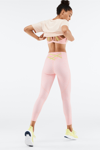

Outfits {'score': 0.6114318370819092, 'label': 'Outfits'}
[{'score': 0.6114318370819092, 'label': 'Outfits'}, {'score': 0.18477672338485718, 'label': 'Bottom'}, {'score': 0.07304225116968155, 'label': 'Top'}, {'score': 0.04647514224052429, 'label': 'Bra'}, {'score': 0.024517282843589783, 'label': 'Savage'}, {'score': 0.01996777020394802, 'label': 'Accessory'}, {'score': 0.013792560435831547, 'label': 'Underwear'}, {'score': 0.013608656823635101, 'label': 'Shoes'}, {'score': 0.012387700378894806, 'label': 'Jacket'}]


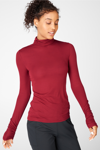

Top {'score': 0.5223919749259949, 'label': 'Top'}
[{'score': 0.5223919749259949, 'label': 'Top'}, {'score': 0.3452454209327698, 'label': 'Outfits'}, {'score': 0.04125729948282242, 'label': 'Bottom'}, {'score': 0.017980679869651794, 'label': 'Accessory'}, {'score': 0.016414670273661613, 'label': 'Bra'}, {'score': 0.014749226160347462, 'label': 'Jacket'}, {'score': 0.014142047613859177, 'label': 'Underwear'}, {'score': 0.013961606658995152, 'label': 'Shoes'}, {'score': 0.01385705266147852, 'label': 'Savage'}]


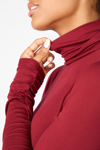

Top {'score': 0.7961314916610718, 'label': 'Top'}
[{'score': 0.7961314916610718, 'label': 'Top'}, {'score': 0.08036413043737411, 'label': 'Outfits'}, {'score': 0.029733970761299133, 'label': 'Bottom'}, {'score': 0.01956961490213871, 'label': 'Bra'}, {'score': 0.01950407773256302, 'label': 'Accessory'}, {'score': 0.014707943424582481, 'label': 'Shoes'}, {'score': 0.014306332916021347, 'label': 'Savage'}, {'score': 0.01319589838385582, 'label': 'Jacket'}, {'score': 0.012486563064157963, 'label': 'Underwear'}]


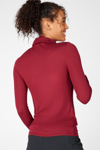

Top {'score': 0.7200960516929626, 'label': 'Top'}
[{'score': 0.7200960516929626, 'label': 'Top'}, {'score': 0.1616562157869339, 'label': 'Outfits'}, {'score': 0.02894166111946106, 'label': 'Bottom'}, {'score': 0.019152192398905754, 'label': 'Accessory'}, {'score': 0.017431901767849922, 'label': 'Bra'}, {'score': 0.013858356513082981, 'label': 'Savage'}, {'score': 0.013796944171190262, 'label': 'Shoes'}, {'score': 0.012715372256934643, 'label': 'Jacket'}, {'score': 0.012351329438388348, 'label': 'Underwear'}]


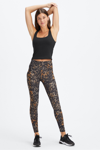

Outfits {'score': 0.6631858348846436, 'label': 'Outfits'}
[{'score': 0.6631858348846436, 'label': 'Outfits'}, {'score': 0.18078862130641937, 'label': 'Bottom'}, {'score': 0.0461474284529686, 'label': 'Bra'}, {'score': 0.041854217648506165, 'label': 'Top'}, {'score': 0.015777843073010445, 'label': 'Accessory'}, {'score': 0.015675503760576248, 'label': 'Savage'}, {'score': 0.013310343027114868, 'label': 'Underwear'}, {'score': 0.011970718391239643, 'label': 'Jacket'}, {'score': 0.01128949411213398, 'label': 'Shoes'}]


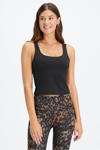

Outfits {'score': 0.4354219138622284, 'label': 'Bottom'}
[{'score': 0.4354219138622284, 'label': 'Bottom'}, {'score': 0.3784055709838867, 'label': 'Outfits'}, {'score': 0.07861743867397308, 'label': 'Top'}, {'score': 0.037343159317970276, 'label': 'Bra'}, {'score': 0.016715245321393013, 'label': 'Underwear'}, {'score': 0.015381217934191227, 'label': 'Accessory'}, {'score': 0.013323700055480003, 'label': 'Savage'}, {'score': 0.01260184682905674, 'label': 'Shoes'}, {'score': 0.012189770117402077, 'label': 'Jacket'}]


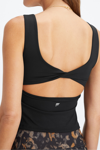

Outfits {'score': 0.6505593061447144, 'label': 'Bra'}
[{'score': 0.6505593061447144, 'label': 'Bra'}, {'score': 0.16636574268341064, 'label': 'Outfits'}, {'score': 0.05983796715736389, 'label': 'Top'}, {'score': 0.026090633124113083, 'label': 'Savage'}, {'score': 0.024839969351887703, 'label': 'Accessory'}, {'score': 0.02247779630124569, 'label': 'Bottom'}, {'score': 0.01951569877564907, 'label': 'Jacket'}, {'score': 0.015379328280687332, 'label': 'Shoes'}, {'score': 0.014933464117348194, 'label': 'Underwear'}]


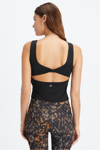

Outfits {'score': 0.511531412601471, 'label': 'Outfits'}
[{'score': 0.511531412601471, 'label': 'Outfits'}, {'score': 0.19511574506759644, 'label': 'Bra'}, {'score': 0.13907848298549652, 'label': 'Bottom'}, {'score': 0.0732533186674118, 'label': 'Top'}, {'score': 0.019811974838376045, 'label': 'Savage'}, {'score': 0.018546344712376595, 'label': 'Accessory'}, {'score': 0.015675760805606842, 'label': 'Underwear'}, {'score': 0.013494540937244892, 'label': 'Shoes'}, {'score': 0.013492334634065628, 'label': 'Jacket'}]


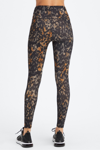

Outfits {'score': 0.4502584636211395, 'label': 'Bottom'}
[{'score': 0.4502584636211395, 'label': 'Bottom'}, {'score': 0.4210274815559387, 'label': 'Outfits'}, {'score': 0.028811326250433922, 'label': 'Bra'}, {'score': 0.02343224361538887, 'label': 'Top'}, {'score': 0.02010914497077465, 'label': 'Underwear'}, {'score': 0.016026504337787628, 'label': 'Accessory'}, {'score': 0.015854056924581528, 'label': 'Savage'}, {'score': 0.012427078559994698, 'label': 'Shoes'}, {'score': 0.012053724378347397, 'label': 'Jacket'}]


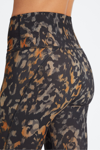

Outfits {'score': 0.525320827960968, 'label': 'Bottom'}
[{'score': 0.525320827960968, 'label': 'Bottom'}, {'score': 0.32642391324043274, 'label': 'Outfits'}, {'score': 0.03220478072762489, 'label': 'Underwear'}, {'score': 0.02993081323802471, 'label': 'Bra'}, {'score': 0.019270576536655426, 'label': 'Accessory'}, {'score': 0.01923917420208454, 'label': 'Top'}, {'score': 0.01778637059032917, 'label': 'Savage'}, {'score': 0.01515031885355711, 'label': 'Shoes'}, {'score': 0.01467323862016201, 'label': 'Jacket'}]


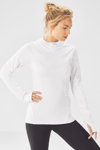

Top {'score': 0.587104082107544, 'label': 'Outfits'}
[{'score': 0.587104082107544, 'label': 'Outfits'}, {'score': 0.26779112219810486, 'label': 'Top'}, {'score': 0.05416463315486908, 'label': 'Bottom'}, {'score': 0.0187001321464777, 'label': 'Accessory'}, {'score': 0.01592901349067688, 'label': 'Bra'}, {'score': 0.014907720498740673, 'label': 'Savage'}, {'score': 0.014692652970552444, 'label': 'Jacket'}, {'score': 0.013888825662434101, 'label': 'Shoes'}, {'score': 0.012821758165955544, 'label': 'Underwear'}]


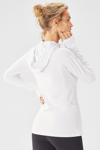

Top {'score': 0.46268752217292786, 'label': 'Top'}
[{'score': 0.46268752217292786, 'label': 'Top'}, {'score': 0.3920753300189972, 'label': 'Outfits'}, {'score': 0.05270567908883095, 'label': 'Bottom'}, {'score': 0.021108707413077354, 'label': 'Accessory'}, {'score': 0.015660006552934647, 'label': 'Savage'}, {'score': 0.01564863510429859, 'label': 'Bra'}, {'score': 0.01377441082149744, 'label': 'Jacket'}, {'score': 0.013509439304471016, 'label': 'Shoes'}, {'score': 0.012830283492803574, 'label': 'Underwear'}]


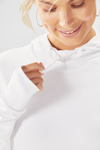

Top {'score': 0.7890632748603821, 'label': 'Top'}
[{'score': 0.7890632748603821, 'label': 'Top'}, {'score': 0.08799925446510315, 'label': 'Outfits'}, {'score': 0.030045421794056892, 'label': 'Bottom'}, {'score': 0.02049591951072216, 'label': 'Accessory'}, {'score': 0.017662417143583298, 'label': 'Bra'}, {'score': 0.01757369376718998, 'label': 'Savage'}, {'score': 0.014305070973932743, 'label': 'Shoes'}, {'score': 0.011491252109408379, 'label': 'Jacket'}, {'score': 0.011363686062395573, 'label': 'Underwear'}]


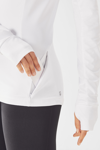

Top {'score': 0.5678189396858215, 'label': 'Top'}
[{'score': 0.5678189396858215, 'label': 'Top'}, {'score': 0.2832951247692108, 'label': 'Outfits'}, {'score': 0.058567654341459274, 'label': 'Bottom'}, {'score': 0.018696602433919907, 'label': 'Accessory'}, {'score': 0.016095392405986786, 'label': 'Savage'}, {'score': 0.015207502990961075, 'label': 'Bra'}, {'score': 0.013770975172519684, 'label': 'Jacket'}, {'score': 0.013422349467873573, 'label': 'Shoes'}, {'score': 0.013125493191182613, 'label': 'Underwear'}]


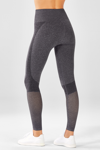

Bottom {'score': 0.5124619603157043, 'label': 'Bottom'}
[{'score': 0.5124619603157043, 'label': 'Bottom'}, {'score': 0.35376131534576416, 'label': 'Outfits'}, {'score': 0.029552092775702477, 'label': 'Bra'}, {'score': 0.028860367834568024, 'label': 'Top'}, {'score': 0.01940212771296501, 'label': 'Underwear'}, {'score': 0.0171213336288929, 'label': 'Accessory'}, {'score': 0.01609712466597557, 'label': 'Savage'}, {'score': 0.011527919210493565, 'label': 'Shoes'}, {'score': 0.011215765960514545, 'label': 'Jacket'}]


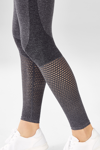

Bottom {'score': 0.5867599248886108, 'label': 'Bottom'}
[{'score': 0.5867599248886108, 'label': 'Bottom'}, {'score': 0.26601138710975647, 'label': 'Outfits'}, {'score': 0.03924788534641266, 'label': 'Top'}, {'score': 0.022742750123143196, 'label': 'Accessory'}, {'score': 0.020649001002311707, 'label': 'Underwear'}, {'score': 0.01871356926858425, 'label': 'Bra'}, {'score': 0.017835691571235657, 'label': 'Shoes'}, {'score': 0.015139777213335037, 'label': 'Savage'}, {'score': 0.012900017201900482, 'label': 'Jacket'}]


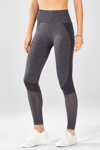

Bottom {'score': 0.6032993793487549, 'label': 'Bottom'}
[{'score': 0.6032993793487549, 'label': 'Bottom'}, {'score': 0.2665342092514038, 'label': 'Outfits'}, {'score': 0.032203350216150284, 'label': 'Top'}, {'score': 0.024747859686613083, 'label': 'Bra'}, {'score': 0.020357169210910797, 'label': 'Underwear'}, {'score': 0.014410351403057575, 'label': 'Accessory'}, {'score': 0.014329575002193451, 'label': 'Savage'}, {'score': 0.012078976258635521, 'label': 'Shoes'}, {'score': 0.012039246037602425, 'label': 'Jacket'}]


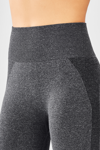

Bottom {'score': 0.5210866928100586, 'label': 'Bottom'}
[{'score': 0.5210866928100586, 'label': 'Bottom'}, {'score': 0.22903478145599365, 'label': 'Outfits'}, {'score': 0.08438706398010254, 'label': 'Underwear'}, {'score': 0.03238816186785698, 'label': 'Bra'}, {'score': 0.030902724713087082, 'label': 'Accessory'}, {'score': 0.027719072997570038, 'label': 'Top'}, {'score': 0.027560343965888023, 'label': 'Shoes'}, {'score': 0.02412315271794796, 'label': 'Jacket'}, {'score': 0.022797951474785805, 'label': 'Savage'}]


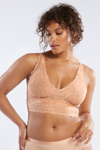

Savage {'score': 0.5150253772735596, 'label': 'Savage'}
[{'score': 0.5150253772735596, 'label': 'Savage'}, {'score': 0.1141696646809578, 'label': 'Bra'}, {'score': 0.0902184247970581, 'label': 'Accessory'}, {'score': 0.05113915726542473, 'label': 'Shoes'}, {'score': 0.04846799746155739, 'label': 'Outfits'}, {'score': 0.04764138162136078, 'label': 'Bottom'}, {'score': 0.04534991458058357, 'label': 'Top'}, {'score': 0.044396933168172836, 'label': 'Underwear'}, {'score': 0.043591126799583435, 'label': 'Jacket'}]


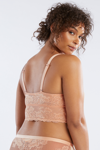

Savage {'score': 0.5253205895423889, 'label': 'Savage'}
[{'score': 0.5253205895423889, 'label': 'Savage'}, {'score': 0.1093461886048317, 'label': 'Bra'}, {'score': 0.09227628260850906, 'label': 'Accessory'}, {'score': 0.049764879047870636, 'label': 'Outfits'}, {'score': 0.04951859265565872, 'label': 'Shoes'}, {'score': 0.047346603125333786, 'label': 'Top'}, {'score': 0.042360808700323105, 'label': 'Underwear'}, {'score': 0.042210936546325684, 'label': 'Bottom'}, {'score': 0.04185505583882332, 'label': 'Jacket'}]


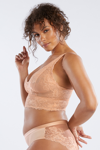

Savage {'score': 0.5062410831451416, 'label': 'Savage'}
[{'score': 0.5062410831451416, 'label': 'Savage'}, {'score': 0.10818047821521759, 'label': 'Accessory'}, {'score': 0.09510992467403412, 'label': 'Bra'}, {'score': 0.05908851698040962, 'label': 'Bottom'}, {'score': 0.0517825186252594, 'label': 'Shoes'}, {'score': 0.05069245398044586, 'label': 'Outfits'}, {'score': 0.04727759584784508, 'label': 'Underwear'}, {'score': 0.042423784732818604, 'label': 'Jacket'}, {'score': 0.03920365497469902, 'label': 'Top'}]


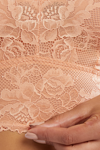

Savage {'score': 0.4715246260166168, 'label': 'Savage'}
[{'score': 0.4715246260166168, 'label': 'Savage'}, {'score': 0.0897517278790474, 'label': 'Accessory'}, {'score': 0.08909648656845093, 'label': 'Bra'}, {'score': 0.07480426132678986, 'label': 'Top'}, {'score': 0.06819991767406464, 'label': 'Bottom'}, {'score': 0.055397093296051025, 'label': 'Underwear'}, {'score': 0.05437524616718292, 'label': 'Outfits'}, {'score': 0.05105012282729149, 'label': 'Shoes'}, {'score': 0.045800525695085526, 'label': 'Jacket'}]


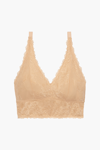

Savage {'score': 0.37406328320503235, 'label': 'Savage'}
[{'score': 0.37406328320503235, 'label': 'Savage'}, {'score': 0.14379464089870453, 'label': 'Accessory'}, {'score': 0.09799204766750336, 'label': 'Bra'}, {'score': 0.08521558344364166, 'label': 'Shoes'}, {'score': 0.06571551412343979, 'label': 'Underwear'}, {'score': 0.05946185067296028, 'label': 'Top'}, {'score': 0.059156034141778946, 'label': 'Outfits'}, {'score': 0.05790010839700699, 'label': 'Bottom'}, {'score': 0.05670089274644852, 'label': 'Jacket'}]


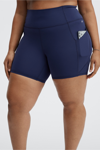

Bottom {'score': 0.7898969650268555, 'label': 'Bottom'}
[{'score': 0.7898969650268555, 'label': 'Bottom'}, {'score': 0.07610279321670532, 'label': 'Outfits'}, {'score': 0.03161562606692314, 'label': 'Underwear'}, {'score': 0.024515893310308456, 'label': 'Top'}, {'score': 0.018490884453058243, 'label': 'Bra'}, {'score': 0.018427681177854538, 'label': 'Accessory'}, {'score': 0.015792595222592354, 'label': 'Savage'}, {'score': 0.013152430765330791, 'label': 'Shoes'}, {'score': 0.012005138210952282, 'label': 'Jacket'}]


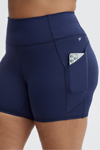

Bottom {'score': 0.6954159140586853, 'label': 'Bottom'}
[{'score': 0.6954159140586853, 'label': 'Bottom'}, {'score': 0.10943049192428589, 'label': 'Outfits'}, {'score': 0.06463957577943802, 'label': 'Underwear'}, {'score': 0.02967185340821743, 'label': 'Accessory'}, {'score': 0.022628365084528923, 'label': 'Bra'}, {'score': 0.02087605930864811, 'label': 'Top'}, {'score': 0.020776880905032158, 'label': 'Savage'}, {'score': 0.020158423110842705, 'label': 'Shoes'}, {'score': 0.01640240289270878, 'label': 'Jacket'}]


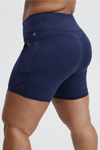

Bottom {'score': 0.805695652961731, 'label': 'Bottom'}
[{'score': 0.805695652961731, 'label': 'Bottom'}, {'score': 0.06756777316331863, 'label': 'Outfits'}, {'score': 0.030259205028414726, 'label': 'Underwear'}, {'score': 0.01991887576878071, 'label': 'Top'}, {'score': 0.01832812838256359, 'label': 'Accessory'}, {'score': 0.016736796125769615, 'label': 'Bra'}, {'score': 0.015329968184232712, 'label': 'Savage'}, {'score': 0.014178451150655746, 'label': 'Shoes'}, {'score': 0.01198512502014637, 'label': 'Jacket'}]


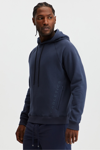

Top {'score': 0.7119312286376953, 'label': 'Top'}
[{'score': 0.7119312286376953, 'label': 'Top'}, {'score': 0.10236561298370361, 'label': 'Bottom'}, {'score': 0.08286172151565552, 'label': 'Outfits'}, {'score': 0.02316991612315178, 'label': 'Accessory'}, {'score': 0.019758792594075203, 'label': 'Savage'}, {'score': 0.016517745330929756, 'label': 'Shoes'}, {'score': 0.015023015439510345, 'label': 'Bra'}, {'score': 0.014936599880456924, 'label': 'Underwear'}, {'score': 0.013435224071145058, 'label': 'Jacket'}]


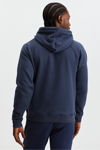

Top {'score': 0.7396240830421448, 'label': 'Top'}
[{'score': 0.7396240830421448, 'label': 'Top'}, {'score': 0.09778596460819244, 'label': 'Outfits'}, {'score': 0.07313340157270432, 'label': 'Bottom'}, {'score': 0.0185083094984293, 'label': 'Savage'}, {'score': 0.017831170931458473, 'label': 'Accessory'}, {'score': 0.013551009818911552, 'label': 'Bra'}, {'score': 0.013546738773584366, 'label': 'Shoes'}, {'score': 0.013541204854846, 'label': 'Underwear'}, {'score': 0.012478025630116463, 'label': 'Jacket'}]
84


In [69]:
ds = load_dataset("./fl_image_category_ds/", split="train")[-100:]
predictions = classifier(ds['image'])
total = 0
correct = 0
for i in range(len(predictions)):
    size = ds['image'][i].size
    display(ds['image'][i].resize((100,int(100 * size[1]/size[0]))))
    total = total + 1
    label = id2label[str(ds['label'][i])]
    prediction = predictions[i][np.argmax([x['score'] for x in predictions[i]])]
    print(label, prediction)
    print(predictions[i])
    if prediction['label'] == label:
        correct = correct + 1
    # print(id2label[str(ds['label'][i])], predictions[i][np.argmax([x['score'] for x in predictions[i]])])
print(correct)